<a href="https://colab.research.google.com/github/mmeierer/RNN---TensorFlow-vs-PyTorch/blob/main/rnn_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series prediction using an RNN with PyTorch

## 1. Import & Preprocessing

### a) Importing modules

In [1]:
# Load required packages - data handling & plotting
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Load required packages - deep learning 
import torch
import torch.nn as nn
import torch.optim as optim

### b) Importing data

In [2]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [3]:
flight_data.shape

(144, 3)

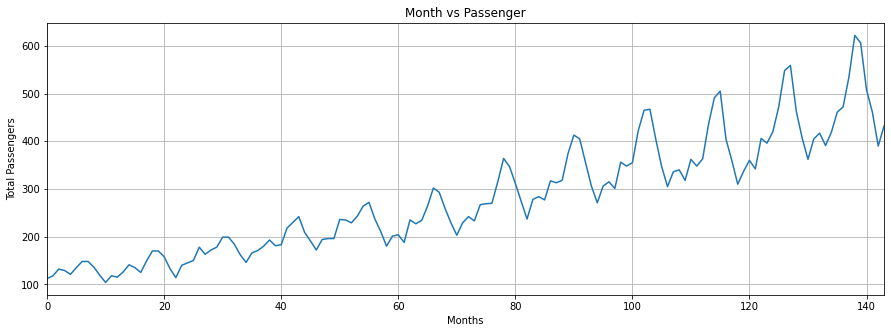

In [4]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

### c) Data preparation

In [5]:
data = flight_data['passengers']

In [6]:
test_size = 12

x_train = data[:-test_size].values.astype(float)
x_test = data[-test_size:].values.astype(float)

In [7]:
x_train.shape

(132,)

In [8]:
x_test.shape

(12,)

In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
x_train = scaler.fit_transform(x_train.reshape(-1, 1))

In [10]:
x_train.shape

(132, 1)

## 2. Model specific data preparation

### a) Load the data

In [11]:
x_train_pt = torch.FloatTensor(x_train).squeeze()

In [12]:
x_train_pt.shape

torch.Size([132])

In [13]:
def create_sequences(input_data, window=12):
    seq = []
    L = len(input_data)
    for i in range(L-window):
        train_seq = input_data[i:i+window]
        train_label = input_data[i+window:i+window+1]
        seq.append((train_seq ,train_label))
    return seq

In [14]:
train_seq_pt = create_sequences(x_train_pt)

In [15]:
len(train_seq_pt)

120

### b) Tensor view of the data

In [16]:
train_seq_pt[0]

(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
         -0.8593, -0.9341, -1.0000, -0.9385]), tensor([-0.9516]))

## 3. Model definition

### a) Build the model

In [17]:
def init_weights(self):
        for m in self.modules():
            if type(m) in [nn.Linear, nn.LSTM]:
                for name, param in m.named_parameters():
                    if 'weight_ih' in name or name == 'weight':
                        torch.nn.init.uniform_(param.data, -1,1)
                    elif 'weight_hh' in name:
                        torch.nn.init.orthogonal_(param.data)
                    elif 'bias' in name:
                        param.data.fill_(0)

In [18]:
class LSTM_PT(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, inputs):
        h0, c0 = self.init_hidden(inputs)
        lstm_out, (hn, cn) = self.lstm(inputs.view(len(inputs) ,-1, 1))
        predictions = self.linear(lstm_out.view(len(inputs), -1))
        return predictions[-1]

    def init_hidden(self, x):
        h0 = torch.zeros(1,1,self.hidden_layer_size)
        c0 = torch.zeros(1,1,self.hidden_layer_size)
        return [t for t in (h0, c0)]

model_pt = LSTM_PT()

In [19]:
model_pt.apply(init_weights)

LSTM_PT(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

### b) Inspect the model

In [20]:
params_pt = model_pt.named_parameters()
for name, param in params_pt:
  print(name)

lstm.weight_ih_l0
lstm.weight_hh_l0
lstm.bias_ih_l0
lstm.bias_hh_l0
linear.weight
linear.bias


### c) Inspect the first hidden layer

In [21]:
model_pt.lstm._parameters['weight_ih_l0']

Parameter containing:
tensor([[-0.5166],
        [ 0.6708],
        [ 0.4491],
        [-0.3411],
        [ 0.2410],
        [-0.0507],
        [ 0.9830],
        [ 0.2330],
        [-0.8370],
        [ 0.6381],
        [-0.5378],
        [ 0.1410],
        [ 0.9453],
        [ 0.9464],
        [-0.7492],
        [ 0.5484],
        [-0.4564],
        [-0.0374],
        [-0.2377],
        [-0.2031],
        [ 0.2918],
        [-0.3824],
        [-0.6939],
        [ 0.6686],
        [ 0.0075],
        [ 0.6120],
        [-0.4711],
        [-0.2174],
        [ 0.3275],
        [-0.0676],
        [-0.7249],
        [-0.3762],
        [-0.2630],
        [ 0.2026],
        [ 0.4343],
        [ 0.5647],
        [ 0.2159],
        [-0.7060],
        [-0.2601],
        [ 0.6705],
        [ 0.9981],
        [ 0.1990],
        [ 0.0689],
        [-0.9328],
        [ 0.6019],
        [ 0.9590],
        [ 0.9705],
        [-0.9622],
        [-0.8823],
        [ 0.0045],
        [-0.5794],
        [

In [22]:
model_pt.lstm._parameters['weight_ih_l0'].shape

torch.Size([400, 1])

In [23]:
model_pt.lstm._parameters['bias_ih_l0']

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.

In [24]:
model_pt.lstm._parameters['bias_ih_l0'].shape

torch.Size([400])

## 4. Loss & Optimizer

In [25]:
optimizer_pt = torch.optim.Adam(model_pt.parameters())
loss_fn_pt = nn.MSELoss()

## 5. Training

### a) Training loop

In [26]:
def train_step_pt(model, optimizer, loss_fn, sequence):
  total_loss = 0.0

  for seq, label in sequence:
    optimizer.zero_grad()
    y_pred_pt = model(seq)
          
    loss = loss_fn(y_pred_pt,label)

    loss.backward()
    optimizer.step()
    total_loss += np.sum(loss.data.numpy())
  return total_loss/len(seq)

In [27]:
train_loss_pt = []

epochs = 25
for epoch in range(epochs):
  
  loss = train_step_pt(model_pt, optimizer_pt, loss_fn_pt,train_seq_pt)
  train_loss_pt.append(loss)

  template = ("Epoch {}, Loss: {}")
  print(template.format(epoch+1, loss))

Epoch 1, Loss: 1.0535830198017113
Epoch 2, Loss: 0.7538906967331324
Epoch 3, Loss: 0.2742559448341619
Epoch 4, Loss: 0.26057618147483524
Epoch 5, Loss: 0.20543052748948298
Epoch 6, Loss: 0.17143489181292657
Epoch 7, Loss: 0.20522546350814727
Epoch 8, Loss: 0.20887174556097912
Epoch 9, Loss: 0.3895878175802257
Epoch 10, Loss: 0.4166945183926245
Epoch 11, Loss: 0.6852843469143627
Epoch 12, Loss: 0.1894623926583184
Epoch 13, Loss: 0.16410702574416072
Epoch 14, Loss: 0.16623097192689804
Epoch 15, Loss: 0.16906848252127796
Epoch 16, Loss: 0.16937884449345594
Epoch 17, Loss: 0.16902050296736615
Epoch 18, Loss: 0.16753286878259152
Epoch 19, Loss: 0.16806228609065377
Epoch 20, Loss: 0.17158322489790598
Epoch 21, Loss: 0.26485223304242805
Epoch 22, Loss: 0.3168134309137803
Epoch 23, Loss: 0.3998474779197802
Epoch 24, Loss: 0.569102542457396
Epoch 25, Loss: 0.20766733582058805


### b) Training progress

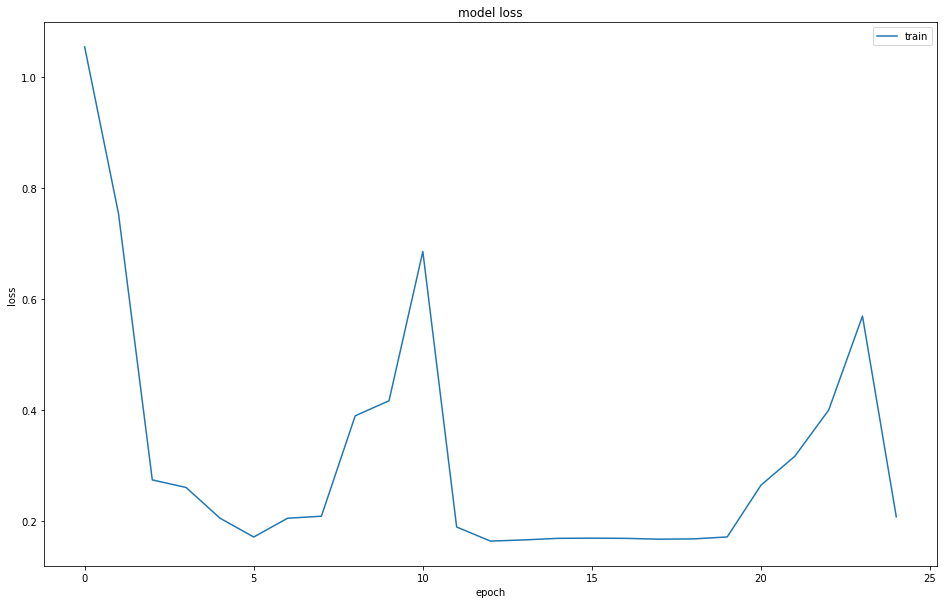

In [28]:
plt.figure(figsize=(16,10))
plt.plot(train_loss_pt)
#plt.plot(test_loss_tf)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

### c) Inspect the first hidden layer after training

In [29]:
model_pt.lstm._parameters['weight_ih_l0']

Parameter containing:
tensor([[-0.4345],
        [ 0.6729],
        [ 0.5392],
        [-0.3396],
        [ 0.2616],
        [-0.0089],
        [ 1.0027],
        [ 0.2527],
        [-0.8176],
        [ 0.6559],
        [-0.5120],
        [ 0.2000],
        [ 0.9777],
        [ 0.9728],
        [-0.7365],
        [ 0.6514],
        [-0.3754],
        [-0.0622],
        [-0.2051],
        [-0.1562],
        [ 0.3416],
        [-0.3713],
        [-0.6498],
        [ 0.7353],
        [ 0.0642],
        [ 0.6388],
        [-0.4580],
        [-0.1126],
        [ 0.3382],
        [-0.0509],
        [-0.7030],
        [-0.3561],
        [-0.1817],
        [ 0.2408],
        [ 0.5315],
        [ 0.6511],
        [ 0.2423],
        [-0.6788],
        [-0.2819],
        [ 0.6947],
        [ 0.9979],
        [ 0.2084],
        [ 0.1193],
        [-0.8993],
        [ 0.6153],
        [ 1.0453],
        [ 0.9856],
        [-0.9357],
        [-0.8123],
        [ 0.0970],
        [-0.5467],
        [

In [30]:
model_pt.lstm._parameters['bias_ih_l0']

Parameter containing:
tensor([-2.7101e-02, -1.3127e-01, -1.0881e-01, -1.3218e-02, -1.4142e-02,
        -1.7062e-01, -3.4224e-02, -1.6700e-02,  8.6864e-03, -1.3284e-01,
        -9.1837e-02, -1.0405e-02, -9.7734e-02, -1.7850e-02,  2.2924e-03,
        -1.2776e-02, -6.0172e-02, -2.5733e-01, -9.2851e-02,  1.4093e-02,
        -1.1294e-02, -9.5085e-03, -7.9985e-02, -4.1716e-02, -1.3764e-01,
        -9.2165e-03,  3.5346e-02, -6.4492e-02, -1.8033e-01, -2.3832e-03,
        -3.4927e-03, -4.8082e-02,  2.4408e-03, -1.1169e-01, -1.5221e-01,
        -1.3655e-01, -1.0698e-01, -1.8001e-02, -1.8006e-01, -8.0799e-02,
        -1.5084e-01, -5.1033e-02, -1.4090e-01, -2.4558e-02, -2.8165e-02,
        -1.1619e-02, -8.5486e-03, -3.5187e-03, -1.0784e-01, -1.8717e-01,
        -1.1457e-01, -1.2999e-01, -1.0210e-01, -7.1516e-02, -1.1438e-01,
        -4.3013e-02, -6.5938e-02, -4.4473e-02, -1.0757e-01, -5.6251e-03,
        -2.4440e-02, -1.2696e-01, -1.3279e-01, -8.6134e-02,  8.7757e-03,
        -2.7975e-02, -9.6612e

## 6. Evaluation

### a) Prediction comparing to the test set

In [31]:
test_inputs_overlap_pt = x_train[-12:].tolist()

In [32]:
test_inputs_overlap_pt

[[0.12527472527472527],
 [0.04615384615384621],
 [0.32747252747252764],
 [0.2835164835164836],
 [0.3890109890109892],
 [0.6175824175824178],
 [0.9516483516483516],
 [1.0000000000000002],
 [0.578021978021978],
 [0.331868131868132],
 [0.13406593406593403],
 [0.32307692307692304]]

In [33]:
for i in range(12):
    seq = torch.FloatTensor(test_inputs_overlap_pt[-12:])
    with torch.no_grad():
        test_inputs_overlap_pt.append([model_pt(seq).item()])

In [34]:
test_inputs_overlap_pt[-12:]

[[0.5052933096885681],
 [0.6298637986183167],
 [0.6748303771018982],
 [0.6445773243904114],
 [0.5720041394233704],
 [0.5025739669799805],
 [0.4704206883907318],
 [0.48266708850860596],
 [0.5217533111572266],
 [0.5625163912773132],
 [0.5870072841644287],
 [0.5893124938011169]]

In [35]:
overlap_predictions_pt = scaler.inverse_transform(np.array(test_inputs_overlap_pt[-12:] ).reshape(-1, 1))
print(overlap_predictions_pt)

[[446.45422795]
 [474.79401419]
 [485.02391079]
 [478.1413413 ]
 [461.63094172]
 [445.83557749]
 [438.52070661]
 [441.30676264]
 [450.19887829]
 [459.47247902]
 [465.04415715]
 [465.56859234]]


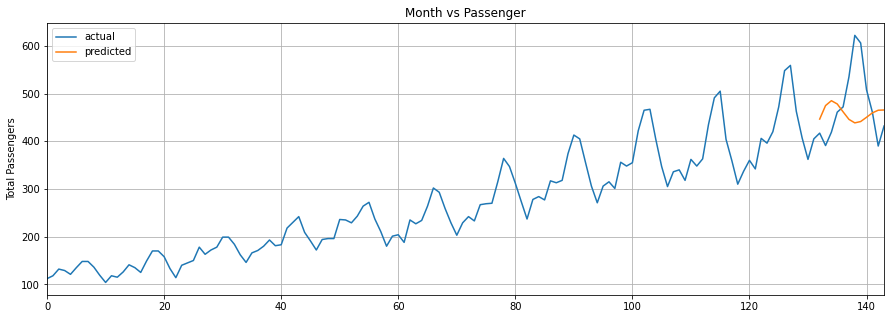

In [36]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(np.arange(132, 144, 1),overlap_predictions_pt)
plt.legend(['actual', 'predicted'], loc='upper left')
plt.show()

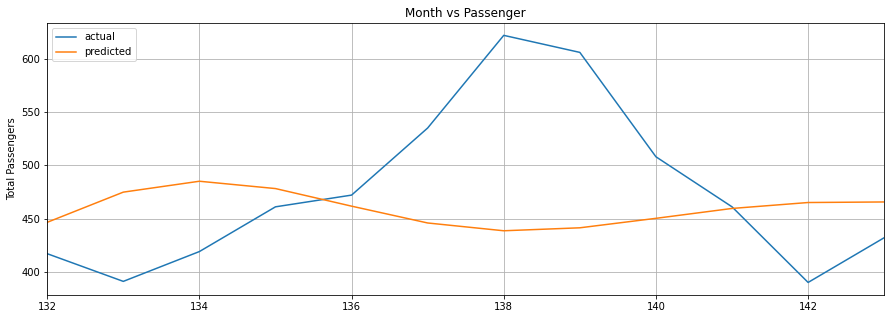

In [37]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'][-12:])
plt.plot(np.arange(132, 144, 1),overlap_predictions_pt)
plt.legend(['actual', 'predicted'], loc='upper left')
plt.show()

### b) Prediction into the future using the test set

In [38]:
scaler = MinMaxScaler(feature_range=(-1, 1))
x_test_pt = scaler.fit_transform(x_test.reshape(-1, 1))

In [39]:
test_inputs_pt = x_test_pt[-12:].tolist()

In [40]:
test_inputs_pt

[[-0.7672413793103456],
 [-0.9913793103448283],
 [-0.7500000000000004],
 [-0.38793103448275934],
 [-0.293103448275863],
 [0.2499999999999991],
 [0.9999999999999991],
 [0.8620689655172411],
 [0.017241379310344307],
 [-0.38793103448275934],
 [-1.0000000000000004],
 [-0.6379310344827593]]

In [41]:
for i in range(12):
    seq = torch.FloatTensor(test_inputs_pt[-12:])
    with torch.no_grad():
        test_inputs_pt.append([model_pt(seq).item()])

In [42]:
test_inputs_pt[-12:]

[[-0.3825359344482422],
 [-0.186520516872406],
 [-0.04562642425298691],
 [0.041437506675720215],
 [0.0878540575504303],
 [0.11370861530303955],
 [0.13673727214336395],
 [0.16716167330741882],
 [0.20699875056743622],
 [0.25538545846939087],
 [0.3102723956108093],
 [0.3696688413619995]]

In [43]:
predictions_pt = scaler.inverse_transform(np.array(test_inputs_pt[-12:] ).reshape(-1, 1))
print(predictions_pt)

[[461.6258316 ]
 [484.36362004]
 [500.70733479]
 [510.80675077]
 [516.19107068]
 [519.19019938]
 [521.86152357]
 [525.3907541 ]
 [530.01185507]
 [535.62471318]
 [541.99159789]
 [548.8815856 ]]


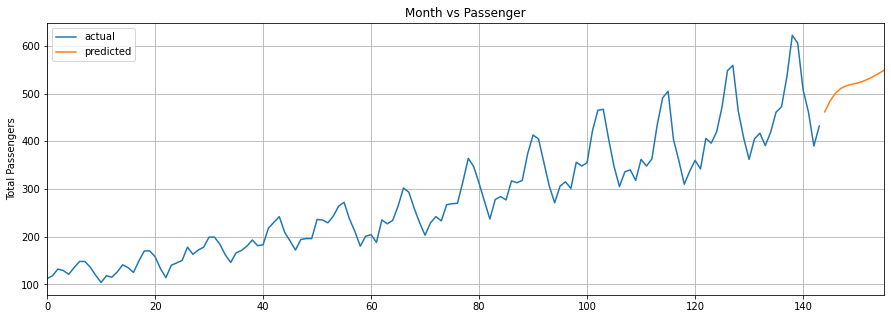

In [44]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(np.arange(144, 156, 1),predictions_pt)
plt.legend(['actual', 'predicted'], loc='upper left')
plt.show()

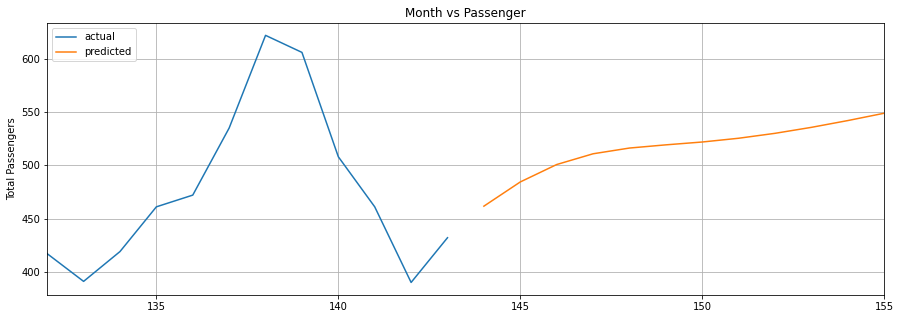

In [45]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'][-12:])
plt.plot(np.arange(144, 156, 1),predictions_pt)
plt.legend(['actual', 'predicted'], loc='upper left')
plt.show()